# <img src="https://img.icons8.com/dusk/64/000000/mind-map.png" style="height:50px;display:inline"> CS 236756 - Technion - Intro to Machine Learning
---
#### Tal Daniel

## Tutorial 13 - Deep Learning Introduction & Backpropagation
---

<img src="./assets/tut_12_intro.jpg" style="height:200px">

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Motivation](#-Motivation)
    * [Demo - Solving the XOR Problem](#-Demo---Solving-the-XOR-Problem)
* [Problem Formulation](#-The-Optimization-Problem)
    * [Optimization Problem](#-The-Optimization-Problem)
    * [Multi-Layer Perceptron (MLP)](#-Multi-Layer-Perceptron-(MLP) )
* [Modular Approach](#-Modular-Approach)
    * [Building Blocks & Backpropagation](#-Backpropagation)
* [Regression Problem](#-Example---Neural-Networks-for-Regression---Housing-Prices)
* [Backpropagation By Hand Exercise](#-Backpropagation-By-Hand--Exercise)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
%matplotlib notebook

## <img src="https://img.icons8.com/dusk/64/000000/confetti.png" style="height:50px;display:inline"> Motivation
---
* From the biological perspective, it seems logical to look at the brain's architecture for inspiration on how to build an intelligent machine. 
* This is the main idea that inspired *artificial neural networks* (ANN) which later developed into *deep neural networks* (DNN)

### <img src="https://img.icons8.com/bubbles/100/000000/lightning-bolt.png" style="height:50px;display:inline"> The Perceptron Expressive Power
---
#### Reminder (Tutorial 9) - The Perceptron

* Based on a *linear threshold unit* (LTU): the input and output are numbers (not binary values), and each connection is associated with a weight.
* The LTU computes a weighted sum of its inputs: $z = w_1x_1 + w_2x_2 +....+w_nx_n = w_Tx$, and then it applies a **step function** to that sum and outputs the result: $$ h_w(x) = step(z) = step(w^Tx) $$

Illustration: <img src="./assets/tut_09_perceptron.jpg" style="height:200px">

* The most common step function used is the *Heaviside step function* but sometimes the *sign function* is used (as is the illustration).
* **Perceptron Training** draws inspiration from biological neurons: the connection weight between two neurons is increased whenever they have **the same output**. Perceptrons are trained by considering the error made.
    * At each iteration, the Perceptron is fed with one training instance and makes a prediction for it.
    * For every output that produced a wrong prediction, it reinforces the connection weights from the inputs that would ahve contributed to the correct prediction.
    * Criterion: $ E^{perc}(w) = - \sum_{i \in D_{miss}}w^T(x^iy^i) $
* **Perceptron Learning Rule (weight update)**: $$ w_{t+1} = w_t +\eta(y_i -sign(w_t^Tx_i))x_i $$
    * $\eta$ is the learing rate
* The decision boundary learned is linear, the Perceptron is incapable of learning complex patterns.

* **Perceptron Convergence Theorem**: If the training instances are **linearly seperable**, the algorithm would converge to a solution.
    * **There can be multiple solutions (multiple hyperplanes)**
* Perceptrons do not output a class probability, they just make predicitons based on a **hard threshold** (they output an un-normalized score).

* **What mappings can a Perceptron represent perfectly?**
    * The Perceptron is a **linear classifier**.
    * Thus, it can represent any mapping that is linearly separable.
        * Some Boolean functions like *AND* and *OR* (left figure)
        * But not Boolean functions like *XOR* (right figure)

* This was demonstrated in the work of Minsky and Papert named *Perceptron*, 1969:

<img src="./assets/tut_12_boolean.jpg" style="height:200px">

###  <img src="https://img.icons8.com/dusk/64/000000/classroom.png" style="height:50px;display:inline"> Demo - Solving the XOR Problem
---
In the XOR problem we have 2 classes such that:

| Input | Output   |
|------|------|
|   [-1,-1]  | 0|
|   [-1,1]  | 1|
|   [1,1]  | 0|
|   [1,-1]  | 1|

In [2]:
def plot_xor_problem():
    x1 = [-1, 1]
    y1 = [-1, 1]
    x2 = [-1, 1]
    y2 = [1, -1]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x1, y1, 'ro')
    ax.plot(x2, y2, 'bo')
    ax.grid()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('The XOR problem')

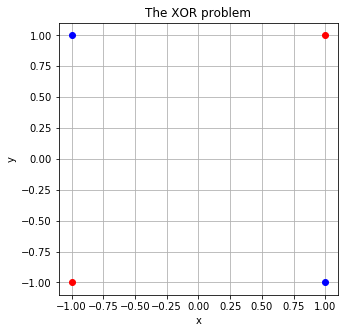

In [3]:
# the xor problem
plot_xor_problem()

### <a href="https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=5&seed=0.35101&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false"> Online Demo (@ TensorFlow) </a>
* Parameters to play with:
    * Number of layers
    * Feature construction (add $x_1x_2$ and see what happens)
    * Problem Type: change from classification to regression

## <img src="https://img.icons8.com/bubbles/100/000000/maintenance.png" style="height:50px;display:inline"> The Optimization Problem
---
<img src="./assets/tut_12_optim_general.jpg" style="height:200px">

* The Design Variables (Parameters)
    * The network weights
* The problem:
    * Search for the weights' values that minimize the **loss function**

### <img src="https://img.icons8.com/dusk/100/000000/stocks.png" style="height:50px;display:inline"> Reminder - Regression (Tutorial 8)
---
To find the value of $\theta$ that minimizes the cost function, there is a *closed-form solution* - a mathemtical equation that gives the result directly. It is also called the **Normal Equation**. We will now derive it.

* We wish to find a solution for $\hat{y} = X \theta$
* The parameters $\theta$ are obtained by minimzing the *sum of squared* errors or residuals (SSE): $$ SSE(\theta) = \sum_{i=1}^n (\theta^T x_i - y_i)^2 = ||X \theta -y ||_2^2 = (X\theta -y)^T(X\theta - y) = \theta^TX^TX\theta -\theta^Tx^Ty - y^TX\theta +y^Ty$$
* Minimizing w.r.t to $\theta$: $$\nabla_{\theta}SSE(\theta) = 2X^TX\theta - 2X^Ty = 0 \rightarrow \theta^{*} = (X^TX)^{-1}X^Ty $$
* The matrix $(X^TX)^{-1}X^T$ is the *Pseudo Inverse* of $X$
* **How do we solve the multi layer model?**
    * The inputs of every layer is now the output of the previous layer ($X$ is not just the original input)
    * We have weights for every layer, that is, $w$ is now a matrix $W$


### <img src="https://img.icons8.com/dusk/64/000000/layers.png" style="height:50px;display:inline"> Multi-Layer Perceptron (MLP)
---
* An MLP is composed of one input layer, one or more hidden layers and a final output layer. 
* Every layer, except the output layer includes a **bias neuron** which is fully connected to the next layer. 
* When the number of hidden layers is larger than 2, the network is usually called a deep neural network (DNN).

* The algorithm is composed of two main parts: **forward pass and backward pass**.
* In the *forward pass*, for each training instance, the algorithm feeds it to the network and computes the output of every neuron in each consecutive layer (using the network for prediction is just doing a forward pass). 
* Then, the output error (the difference between the desired output and the actual output from the network) is computed.

* After the output error calculation, the network calculates how much each neuron in the last hidden layer contributed to the output error (using the **chain rule**).
* It then proceeds to measure how much of these error contributions came from each neuron in the previous layers until reaching the input layer. 
* This is the *backward pass*: measuring the error gradient across all the connection weights in the network by propagating the error gradient backward in the network (this is the backpropagation process).

In short: for each training instance the **backpropagation algorithm** first makes a prediction (forward pass), measures the error, then goes in reverse to measure the error contribution from each connection (backward pass) and finally, using Gradient Descent, updates the weights in the direction that reduces the error.

<img src="./assets/tut_12_mlp.jpg" style="height:300px">

For example, if: $$ X \in \mathbb{R}^2 $$ $$ W_1 \in \mathbb{R}^{2 \times 4} $$ $$ W_2 \in \mathbb{R}^{4 \times 3} $$ $$ W_3 \in \mathbb{R}^{3 \times 1} $$ $$ b_1 \in \mathbb{R}^4 $$ $$ b_2 \in \mathbb{R}^3 $$ $$ b_3 \in \mathbb{R} $$ Then: $$ F(X,W) = W_3^T \phi_2(W_2^T\phi_1(W_1^TX + b_1) + b_2) + b_3 $$

The key change made to the Perceptron that brought upon the era of deep learning is the addition of **Activation function** to the output of each neuron. These allow the learning of non-linear functions. We will use three popular activation functions:
1. **Logistic function (sigmoid)**: $\sigma(z) = \frac{1}{1 + e^{-z}}$. The output is in $[0,1]$ which can be used for binary clssification or as a probability (why?)
2. **Hyperbolic tangent function**: $tanh(z) = 2\sigma(2z) - 1$. The output is in $[-1,1]$ which tends to make each layer's output more or less normalized at the beginning of the training (which may speed up convergence).
3. **ReLU (Rectified Linear Unit) function**: $ReLU(z) = max(0,z)$. Continuous but not differentiable at $z=0$. However, it is the most common activation function as it is fast to compute and does not bound the output (which helps with some issues during Gradient Descent).

**The Activation functions derivatives (for the backpropagation)**:
1. $\frac{d\sigma(z)}{dz} = \sigma(z)(1-\sigma(z))$
2. $\frac{d tanh(z)}{dz} = 1 - tanh^2(z)$
3. We define the derivative at 0 to be zero: $\frac{d ReLU(z)}{dz} = 1$ if $x>0$ else $0$

In [4]:
# activation functions
def sigmoid(z, deriv=False):
    output = 1 / (1 + np.exp(-1.0 * z))
    if deriv:
        return output * (1 - output)
    return output

def tanh(z, deriv=False):
    output = np.tanh(z)
    if deriv:
        return 1 - np.square(output)
    return output

def relu(z, deriv=False):
    output = z if z > 0 else 0
    if deriv:
        return 1 if z > 0 else 0
    return output

In [5]:
def plot_activations():
    x = np.linspace(-5, 5, 1000)
    y_sig = sigmoid(x)
    y_tanh = tanh(x)
    y_relu = list(map(lambda z: relu(z), x))
    fig = plt.figure(figsize=(8, 5))
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(x, y_sig, label='sigmoid')
    ax1.plot(x, y_tanh, label='tanh')
    ax1.plot(x, y_relu, label='relu')
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_ylim([-2, 2])
    ax1.set_title('Activation Functions')

    y_sig_derv = sigmoid(x, deriv=True)
    y_tanh_derv = tanh(x, deriv=True)
    y_relu_derv = list(map(lambda z: relu(z, deriv=True), x))
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(x, y_sig_derv, label='sigmoid')
    ax2.plot(x, y_tanh_derv, label='tanh')
    ax2.plot(x, y_relu_derv, label='relu')
    ax2.grid()
    ax2.legend()
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    # ax2.set_ylim([-2, 2])
    ax2.set_title('Activation Functions Derivatives')
    plt.tight_layout()

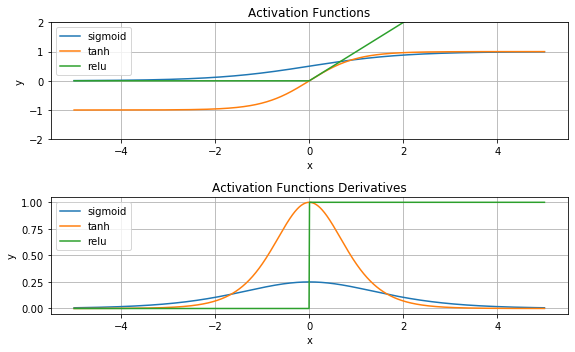

In [6]:
# plot
plot_activations()

### <img src="https://img.icons8.com/color/96/000000/drill.png" style="height:50px;display:inline"> Optimizing MLPs
---
* Optimization is performed by stochastic gradient descent (SGD) and the chain rule - **backpropagation**.
* Reminder - **The Chain Rule**:
    * Given a function: $F(X)=f(g(x))$
    * Denote: $y=g(x), z=f(y)$
    * The derivative is given by: $$ \frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx} = f'(y)g'(x) = f'(g(x))g'(x) $$

#### <img src="https://img.icons8.com/doodle/96/000000/link.png" style="height:30px;display:inline"> Optimizing MLPs -  Simple Example
---
* Demonstration for a simple 1D regressor: $$ f(x) = w_2 \cdot \sigma(w_1x + b_1) + b_2 $$ $$ E(x,y) = (f(x) - y)^2 $$
    * $\sigma(x)$ is the *sigmoid* function
* Denote: $$ u = w_1x + b_1 $$ $$ v=\sigma(u) $$ $$ z=f(x)=w_2v + b_2 $$

* The derivatives:
    * $\frac{\partial E}{\partial w_2} = \frac{\partial E}{\partial z} \frac{\partial z}{\partial w_2} = 2(f(x)-y) \cdot \sigma(w_1x + b_1)$
    * $\frac{\partial E}{\partial b_2} = \frac{\partial E}{\partial z} \frac{\partial z}{\partial b_2} = 2(f(x)-y) \cdot 1$
    * $\frac{\partial E}{\partial w_1} = \frac{\partial E}{\partial z} \frac{\partial z}{\partial v} \frac{\partial v}{\partial u} \frac{\partial u}{\partial w_1} = 2(f(x)-y) \cdot w_2 \sigma(u)(1-\sigma(u)) \cdot x$
    * $\frac{\partial E}{\partial b_1} = \frac{\partial E}{\partial z} \frac{\partial z}{\partial v} \frac{\partial v}{\partial u} \frac{\partial u}{\partial b_1} = 2(f(x)-y) \cdot w_2 \sigma(u)(1-\sigma(u)) \cdot 1$

### <img src="https://img.icons8.com/color/96/000000/drill.png" style="height:50px;display:inline"> Optimizing MLPs - Cont.
---
* Once we calculated all the derivatives we're done! We can now train MLPs!
* Calculating the derivatives for every network is time consuming and becomes difficult for large networks.
* Rather than explicitly deriving the gradient of the loss function with respect to every variable, we will take a modular approach.

## <img src="https://img.icons8.com/dusk/64/000000/lego-head.png" style="height:50px;display:inline"> Modular Approach
---
* We code **layers**, not networks.
* Layer Specification - each layer needs to provide 3 functions:
    1. The layer output given its input (forward pass)
    2. Derivative with respect to the input
    3. Derivative with respect to parameters

Illustration: <img src="./assets/tut_12_mod_app_1.jpg" style="height:350px">

Zoom-in: <img src="./assets/tut_12_mod_app_2.jpg" style="height:200px">

### <img src="https://img.icons8.com/plasticine/100/000000/serial-tasks.png" style="height:50px;display:inline"> Backpropagation
---
We now establish a common language when it comes to neural networks architecture:
* **Forward Pass**: $Z^{(k+1)} = f(Z^{(k)}) $
* **Backward Pass**: $\delta^{(k+1)} = \frac{\partial E}{\partial Z^{(k+1)}}$
* Applying the **chain rule** for a single layer: $$ \frac{\partial E}{\partial Z^{(k)}} = \frac{\partial E}{\partial Z^{(k+1)}} \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = \delta^{(k+1)}\frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = \delta^{(k+1)}\frac{\partial f(Z^{(k)})}{\partial Z^{(k)}} $$
* The **gradient with respect to layer parameters** (if it has any): $$ \frac{\partial E}{\partial W^{(k)}} = \frac{\partial E}{\partial Z^{(k+1)}} \frac{\partial Z^{(k+1)}}{\partial W^{(k)}} = \delta^{(k+1)} \frac{\partial Z^{(k+1)}}{\partial W^{(k)}}  $$

### <img src="https://img.icons8.com/color/96/000000/3d-glasses.png" style="height:50px;display:inline"> Extension to Multi-Dimensions
---
* $f: \mathbb{R}^n \to \mathbb{R}^m$ is a vector function of a vector variable: $$ f(x) = \begin{bmatrix} f_1(x) \\ \vdots \\ f_m(x) \end{bmatrix}, x \in \mathbb{R}^n, f(x) \in \mathbb{R}^m $$
* The **gradient** is given by: $$ \frac{\partial f_i}{\partial x} = \big[ \frac{\partial f_i(x)}{\partial x_1}, ..., \frac{\partial f_i(x)}{\partial x_n} \big] $$
* The **Jacobian**, $J_f(x) \in \mathbb{R}^{m \times n}$, is given by: $$ J_f(x) = \begin{bmatrix} \frac{\partial f_1(x)}{\partial x}\\ \vdots\\ \frac{\partial f_m(x)}{\partial x} \end{bmatrix} = \begin{bmatrix} \frac{\partial f_1}{\partial x_1} && \cdots && \frac{\partial f_1}{\partial x_n} \\ \vdots && \ddots && \vdots \\ \frac{\partial f_m}{\partial x_1} && \cdots && \frac{\partial f_m}{\partial x_n} \end{bmatrix} $$

* **The Chain Rule**:
    * Given: $$ F: \mathbb{R}^n \to \mathbb{R}^m $$ $$ \phi: \mathbb{R}^m \to \mathbb{R}^k $$ $$ \psi(x)= \phi(F(x)) $$
    * The Jacobian is given by: $$ J_{\psi} = J_{\phi} J_F $$ $$ J_{\phi} \in \mathbb{R}^{k \times m}, J_F \in  \mathbb{R}^{m \times n} \to J_{\psi} \in \mathbb{R}^{k \times n}$$

### <img src="https://img.icons8.com/dusk/64/000000/popular-topic.png" style="height:50px;display:inline"> Commonly Used Layers (as Modular Blocks)
---
* Linear Layer (linear combination of the inputs)
* Activation Layer (usually together with the linear layer, apply a function on the linear combination of weighted inputs): ReLU, Binary Step, Sigmoid, TanH...
* Softmax Layer (Sigmoid for for than 2 classes, outputs the probability of each class)
* Loss Function Layer (MSE, Cross Entropy...)

## <img src="https://img.icons8.com/dusk/64/000000/home.png" style="height:50px;display:inline"> Example - Neural Networks for Regression - Housing Prices
---
* The Housing Prices Dataset:
    * Two input features: *Size* and *Floor*
    * One output: *House Price*
    * **Loss function**: MSE
* Suggested **network architecture**: 2 hidden layers
    * Two inputs, one for each feature
    * Four neurons in the *first hidden layer*
    * Three neurons in the *second hidden layer*
    * One output

Layout: <img src="./assets/tut_12_mlp.jpg" style="height:300px"> $$ F(X,W) = W_3^T \phi_2(W_2^T\phi_1(W_1^TX + b_1) + b_2) + b_3 $$

Where: $$ X \in \mathbb{R}^2 $$ $$ W_1 \in \mathbb{R}^{2 \times 4} $$ $$ W_2 \in \mathbb{R}^{4 \times 3} $$ $$ W_3 \in \mathbb{R}^{3 \times 1} $$ $$ b_1 \in \mathbb{R}^4 $$ $$ b_2 \in \mathbb{R}^3 $$ $$ b_3 \in \mathbb{R} $$

### <img src="https://img.icons8.com/office/80/000000/baby-footprints-path.png" style="height:50px;display:inline"> Step-by-Step Solution
---
* The MSE loss function over all the training examples $x_i$ and the corresponding training targets: $$ Error = \frac{1}{N} \sum_{i=1}^N (F(x_i, W) - y_i)^2 = \frac{1}{N} ||F(X, W) - Y||_2^2 $$
* Linear Layer: $$ u_{out} = W^Tu_{in} + b $$

* Activation Layer:
    * $\phi_1$ and $\phi_2$ are multivariate vector *nonlinear* functions, such that: $$ \phi(U) = \phi(\begin{bmatrix} u_1 \\ \vdots \\ u_n \end{bmatrix}) = \begin{bmatrix} \phi(u_1) \\ \vdots \\ \phi(u_n) \end{bmatrix} $$
    * For **ReLU**: $$ \begin{bmatrix} \phi(u_1) \\ \vdots \\ \phi(u_n) \end{bmatrix} = \begin{bmatrix} \max(0, u_1) \\ \vdots \\ \max(0, u_n) \end{bmatrix} $$ 

In [7]:
def plot_relu():
    x = np.linspace(-5, 5, 1000)
    y_relu = list(map(lambda z: relu(z), x))
    y_relu_derv = list(map(lambda z: relu(z, deriv=True), x))
    fig = plt.figure(figsize=(8,5))
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(x, y_relu, label='relu')
    ax1.plot(x, y_relu_derv, label='relu derivative')
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_ylim([-1, 2])
    ax1.set_title('ReLU Activation Function')

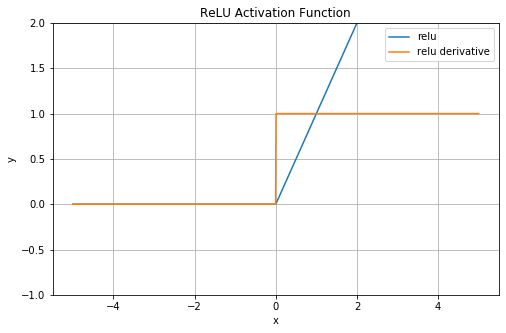

In [8]:
# plot
plot_relu()

#### <img src="https://img.icons8.com/color/96/000000/layers.png" style="height:20px;display:inline"> The Linear Layer
---
* **Forward Pass**: $$Z^{(k+1)} = f(Z^{(k)}) = (W^{(k)})^T Z^{(k)} + b^{(k)}$$
    * $k$ denotes the $k^{th}$ layer with the corresponding weights and bias $W^{(k)}, b^{(k)}$
* **Derivative** with respect to *input* $Z^{(k)}$: $$ \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = \frac{\partial ((W^{(k)})^T Z^{(k)} + b^{(k)})}{\partial Z^{(k)}} = (W^{(k)})^T $$ <br> $$ \delta^{(k)} = \delta^{(k+1)} (W^{(k)})^T  $$
* **Derivative** with respect to the *parameters* $W^{(k)}, b^{(k)}$: $$ \frac{\partial Z^{(k+1)}}{\partial W^{(k)}} = Z^{(k)} ,\frac{\partial E}{\partial W^{(k)}} = \delta^{(k+1)} Z^{(k)} $$ <br> $$  \frac{\partial Z^{(k+1)}}{\partial b^{(k)}} = I,  \frac{\partial E}{\partial b^{(k)}} = \delta^{(k+1)}$$

####  <img src="https://img.icons8.com/color/96/000000/layers.png" style="height:20px;display:inline">  The ReLU Layer
---
* **Forward Pass**: $$ Z^{(k+1)} = \begin{bmatrix} max(0,Z_1^{(k)}) \\ \vdots \\ max(0,Z_n^{(k)}) \end{bmatrix}, ReLU(Z): \mathbb{R}^{n} \to \mathbb{R}^n $$
* **Derivative** with respect to *input* $Z^{(k)}$: $$ \phi = max(0,Z^{(k)}), \phi' = heaviside(Z^{(k)}) $$ <br> $$ \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = diag(\phi') $$ <br> $$ \delta^{(k)} = \delta^{(k+1)} diag (\phi') $$
* **Derivative** with respect to the *parameters*: **NO PARAMETERS!**

####  <img src="https://img.icons8.com/color/96/000000/layers.png" style="height:20px;display:inline">  The MSE Layer 
---
* **Forward Pass**: $$ E = Z^{(k+1)} = (Z^{(k)} - y)^2 $$
*  **Derivative** with respect to *input* $Z^{(k)}$: $$ \delta^{(k+1)} = \frac{\partial E}{\partial Z^{(k+1)}} = \frac{\partial E}{\partial E} = 1 $$ <br> $$ \frac{\partial Z^{(k+1)}}{\partial Z^{(k)}} = 2(Z^{(k)} - y) $$ <br> $$ \delta^{(k)} = \delta^{(k+1)} 2(Z^{(k)} - y) =  2(Z^{(k)} - y) $$

### <img src="https://img.icons8.com/dusk/64/000000/fast-forward.png" style="height:50px;display:inline"> Forward Pass
---
$$ F(X,W) = W_3^T \phi_2(W_2^T\phi_1(W_1^TX + b_1) + b_2) + b_3 $$
<img src="./assets/tut_12_forward.jpg" style="height:300px">

### <img src="https://img.icons8.com/dusk/64/000000/rewind.png" style="height:50px;display:inline"> Backward Pass
---
<img src="./assets/tut_12_backward.jpg" style="height:400px">

## <img src="https://img.icons8.com/color/96/000000/python.png" style="height:50px;display:inline"> Scikit-Learn Example
---
We will now demonstrate how to build an MLP in Scikit-Learn, but it is worth noting:
* Every ML researcher has to implement Backpropagation at least once in order to get the deep understanding of how this algorithm works.
* It is very uncommon working with neural network using Scikit-Learn. The are frameworks dedicated for NNs, which allow taking advantage of GPUs. Such frameworks (=libraries) are **TensorFlow** (maintained by Google) and **PyTorch** (maintained by Facebook) for example.
<img src="http://www.freelogovectors.net/wp-content/uploads/2018/07/tensorflow-logo.png" style="height:50px">
<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" style="height:50px">

In [9]:
# let's load the boston housing dataset
boston_dataset = load_boston()
# print description of the features
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [10]:
# the target is the MEDV field - median value of owner-occupied homes in 1000$
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.sample(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
311,0.79041,0.0,9.90,0.0,0.544,6.122,52.8,2.6403,4.0,304.0,18.4,396.90,5.98,22.1
328,0.06617,0.0,3.24,0.0,0.460,5.868,25.8,5.2146,4.0,430.0,16.9,382.44,9.97,19.3
470,4.34879,0.0,18.10,0.0,0.580,6.167,84.0,3.0334,24.0,666.0,20.2,396.90,16.29,19.9
46,0.18836,0.0,6.91,0.0,0.448,5.786,33.3,5.1004,3.0,233.0,17.9,396.90,14.15,20.0
294,0.08199,0.0,13.92,0.0,0.437,6.009,42.3,5.5027,4.0,289.0,16.0,396.90,10.40,21.7
160,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50,27.0
87,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
44,0.12269,0.0,6.91,0.0,0.448,6.069,40.0,5.7209,3.0,233.0,17.9,389.39,9.55,21.2
105,0.13262,0.0,8.56,0.0,0.520,5.851,96.7,2.1069,5.0,384.0,20.9,394.05,16.47,19.5
418,73.53410,0.0,18.10,0.0,0.679,5.957,100.0,1.8026,24.0,666.0,20.2,16.45,20.62,8.8


In [11]:
# splitting to train and test (no need for valdiation, sklearn takes it from the train set)
# we will use 2 features
x = boston[['RM', 'LSTAT']].values  # RM-num rooms, LSTAT-% lower status of the population
y = boston['MEDV'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=5)
# scaling
x_scaler = StandardScaler()
x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)
print("total training samples: {}, total test samples: {}".format(len(x_train),len(x_test)))

total training samples: 404, total test samples: 102


In [12]:
# train an MLP
# scoring is using the R^2 score -> the best possible score is 1
mlp_reg = MLPRegressor(hidden_layer_sizes=(4, 3,),
                       activation='relu',
                       solver='sgd',
                       batch_size=32,
                       learning_rate_init=0.001,
                       max_iter=200,
                       shuffle=True,
                       random_state=5,
                       early_stopping=True,
                       validation_fraction=0.1,
                       verbose=True)

In [13]:
mlp_reg.fit(x_train, y_train)

Iteration 1, loss = 311.17377473
Validation score: -5.025490
Iteration 2, loss = 268.72251319
Validation score: -4.090056
Iteration 3, loss = 221.29791391
Validation score: -3.238986
Iteration 4, loss = 181.01058667
Validation score: -2.534500
Iteration 5, loss = 148.16609236
Validation score: -1.938828
Iteration 6, loss = 116.34661767
Validation score: -1.140537
Iteration 7, loss = 69.69816627
Validation score: 0.051736
Iteration 8, loss = 25.77497218
Validation score: 0.540522
Iteration 9, loss = 15.90205835
Validation score: 0.577223
Iteration 10, loss = 13.61650701
Validation score: 0.606377
Iteration 11, loss = 12.96205861
Validation score: 0.609462
Iteration 12, loss = 12.55515383
Validation score: 0.623108
Iteration 13, loss = 12.32375027
Validation score: 0.634032
Iteration 14, loss = 12.08402963
Validation score: 0.645485
Iteration 15, loss = 11.87488789
Validation score: 0.648403
Iteration 16, loss = 11.43187277
Validation score: 0.658779
Iteration 17, loss = 11.26966664
Vali

MLPRegressor(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(4, 3), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=5, shuffle=True, solver='sgd', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [14]:
# MSE loss
y_pred = mlp_reg.predict(x_test)
loss = np.mean(np.square(y_test - y_pred))
print("regression using mlp - MSE loss: {:.3f}".format(loss))
# example
sample = 1
print("original price: ${}".format(y_test[sample]))
print("predicted price: ${:.3f}".format(y_pred[sample]))

regression using mlp - MSE loss: 14.537
original price: $27.9
predicted price: $29.250


### <img src="https://img.icons8.com/office/80/000000/pullups--v2.png" style="height:50px;display:inline"> Backpropagation By Hand  Exercise
---
We will now solve a simple backpropagation exercise from <a href="https://www.anotsorandomwalk.com/backpropagation-example-with-numbers-step-by-step/"> A Not So Random Walk </a>. Consider the following network:
<img src="./assets/tut_12_ex_1.png" style="height:300px">

#### Step 0 - Define Dataset and Network Architecture

We will work with one sample for this example, but it can be extended to mini-batches.

* Input: $x = \begin{bmatrix} 1 \\ 4 \\ 5 \end{bmatrix} \in \mathbb{R}^3$
* Output (target): $ t = \begin{bmatrix} 0.1 \\ 0.05 \end{bmatrix} \in \mathbb{R}^2 $
* Number of Hidden Layers: 1
* Activation: Sigmoid for both hidden and output layers
* Loss Functions: MSE

#### Step 1 - Initialization

We initialize the weights and biases to random values as follows:
<img src="./assets/tut_12_ex_2.png" style="height:300px">

#### Step 2 - Forward Pass

We denote:

* $ z_{h_1}, z_{h_2}$ - the weighted output of the hidden neurons **before** activation
* $ h_1 = \sigma(z_{h_1}),  h_2 = \sigma(z_{h_2})$ - the weighted output of the hidden neurons **after** activation
* $ z_{o_1}, z_{o_2}$ - the weighted output of the output neurons **before** activation
* $ o_1 = \sigma(z_{o_1}),  o_2 = \sigma(z_{o_2})$ - the weighted output of the output neurons **after** activation

##### Input -> Hidden Layer

* $z_{h_1} = w_1x_1 + w_3x_2 + w_5x_3 + b_1 = 0.1 * 1 + 0.3 *4 + 0.5 * 5 + 0.5 = 4.3$
* $h_1 = \sigma(z_{h_1}) = \sigma(4.3) = 0.9866$
* $z_{h_2} = w_2x_1 + w_4x_2 + w_6x_3 + b_1 = 0.2 * 1 + 0.4 *4 + 0.6 * 5 + 0.5 = 5.3$
* $h_2 = \sigma(z_{h_2}) = \sigma(4.3) = 0.9950$

##### Hidden Layer -> Output Layer

* $z_{o_1} = w_7h_1 + w_9h_2 + b_2 = 0.7 *0.9866 + 0.9 * 0.9950 + 0.5 = 2.0862$
* $o_1 = \sigma(z_{o_1}) = \sigma(2.0862) = 0.8896$
* $z_{o_2} = w_8h_1 + w_{10}h_2 + b_2 = 0.8 * 0.9866 + 0.1 * 0.9950 + 0.5 = 1.3888$
* $o_2 = \sigma(z_{o_2}) = \sigma(1.3888) = 0.8004$

#### Step 3 - Calculate Error

* MSE: $E = \frac{1}{2}[(o_1 - t_1)^2 + (o_2 - t_2)^2]$
* Derivative w.r.t. the outputs
    * $\frac{\partial E}{\partial o_1} = o_1 - t_1 = 0.7896 $
    * $\frac{\partial E}{\partial o_2} = o_2 - t_2 = 0.7504 $

#### Step 4 - Backropagation

* Reminder: $\sigma'(x) = \sigma(x) (1 - \sigma(x))$

It is basically applying the chain rule!
* $\frac{\partial E}{\partial w_7} = \frac{\partial E}{\partial o_1} \frac{\partial o_1}{\partial z_{o_1}} \frac{\partial z_{o_1}}{\partial w_7} = (o_1 - t_1)(o_1(1-o_1))h_1 = 0.0765$
* $\frac{\partial E}{\partial w_8} = \frac{\partial E}{\partial o_2} \frac{\partial o_2}{\partial z_{o_2}} \frac{\partial z_{o_2}}{\partial w_8} = (o_2 - t_2)(o_2(1-o_2))h_1 = 0.1183$
* $\frac{\partial E}{\partial w_9} = \frac{\partial E}{\partial o_1} \frac{\partial o_1}{\partial z_{o_1}} \frac{\partial z_{o_1}}{\partial w_9} = 0.0772$
* $\frac{\partial E}{\partial w_{10}} = \frac{\partial E}{\partial o_2} \frac{\partial o_2}{\partial z_{o_2}} \frac{\partial z_{o_2}}{\partial w_{10}} = 0.1193$

The second bias is a little more complicated as it is affected by both outputs:
* $\frac{\partial E}{\partial b_2} = \frac{\partial E}{\partial o_1} \frac{\partial o_1}{\partial z_{o_1}} \frac{\partial z_{o_1}}{\partial b_2} + \frac{\partial E}{\partial o_2} \frac{\partial o_2}{\partial z_{o_2}} \frac{\partial z_{o_2}}{\partial b_2} = 0.1975 $
    * $\frac{\partial z_{o_1}}{\partial b_2}, \frac{\partial z_{o_2}}{\partial b_2} = 1$

For our convenience, we will calculate the derivatives w.r.t. $h_1, h_2$ first:
* $\frac{\partial E}{\partial h_1} = \frac{\partial E}{\partial o_1} \frac{\partial o_1}{\partial z_{o_1}} \frac{\partial z_{o_1}}{\partial h_1} + \frac{\partial E}{\partial o_2} \frac{\partial o_2}{\partial z_{o_2}} \frac{\partial z_{o_2}}{\partial h_1} = 0.1502 $
    * $\frac{\partial z_{o_1}}{\partial h_1} = w_7, \frac{\partial z_{o_2}}{\partial h_1} = w_8$
* $\frac{\partial E}{\partial h_2} = \frac{\partial E}{\partial o_1} \frac{\partial o_1}{\partial z_{o_1}} \frac{\partial z_{o_1}}{\partial h_2} + \frac{\partial E}{\partial o_2} \frac{\partial o_2}{\partial z_{o_2}} \frac{\partial z_{o_2}}{\partial h_2} = 0.0818 $
    * $\frac{\partial z_{o_1}}{\partial h_2} = w_9, \frac{\partial z_{o_2}}{\partial h_2} = w_{10}$

Let's continue:
* $\frac{\partial E}{\partial w_1} = \frac{\partial E}{\partial h_1} \frac{\partial h_1}{\partial z_{h_1}} \frac{\partial z_{h_1}}{\partial w_1} = 0.0020 $
    * $\frac{\partial h_1}{\partial z_{h_1}} = h_1 (1-h_1)$
    * $\frac{\partial z_{h_1}}{\partial w_1} = x_1 $
* $\frac{\partial E}{\partial w_3} = \frac{\partial E}{\partial h_1} \frac{\partial h_1}{\partial z_{h_1}} \frac{\partial z_{h_1}}{\partial w_3} = 0.0079 $
* $\frac{\partial E}{\partial w_5} = \frac{\partial E}{\partial h_1} \frac{\partial h_1}{\partial z_{h_1}} \frac{\partial z_{h_1}}{\partial w_5} = 0.0099 $

Similarly:
* $\frac{\partial E}{\partial w_2} = \frac{\partial E}{\partial h_2} \frac{\partial h_2}{\partial z_{h_2}} \frac{\partial z_{h_2}}{\partial w_2} = 0.0004 $
    * $\frac{\partial h_2}{\partial z_{h_2}} = h_2 (1-h_2)$
    * $\frac{\partial z_{h_2}}{\partial w_2} = x_1 $
* $\frac{\partial E}{\partial w_4} = \frac{\partial E}{\partial h_2} \frac{\partial h_2}{\partial z_{h_2}} \frac{\partial z_{h_2}}{\partial w_4} = 0.0016 $
* $\frac{\partial E}{\partial w_6} = \frac{\partial E}{\partial h_2} \frac{\partial h_2}{\partial z_{h_2}} \frac{\partial z_{h_2}}{\partial w_6} = 0.0020 $

The first bias:
* $\frac{\partial E}{\partial b_1} =  \frac{\partial E}{\partial o_1} \frac{\partial o_1}{\partial z_{o_1}} \frac{\partial z_{o_1}}{\partial h_1} \frac{\partial h_1 }{\partial z_{h_1}} \frac{\partial z_{h_1} }{\partial b_1} + \frac{\partial E}{\partial o_2} \frac{\partial o_2}{\partial z_{o_2}} \frac{\partial z_{o_2}}{\partial h_2} \frac{\partial h_2 }{\partial z_{h_2}} \frac{\partial z_{h_2} }{\partial b_1} = 0.0008$

#### Step 5 - Update Weights

We will use learning rate $\alpha = 0.01$:
* $w_1 := w_1 - \alpha \frac{\partial E}{\partial w_1} = 0.1 - 0.01 * 0.0020 = 0.1$
* $w_2 := w_2 - \alpha \frac{\partial E}{\partial w_2} = 0.2 - 0.01 * 0.0004 = 0.2$
* $w_3 := w_3 - \alpha \frac{\partial E}{\partial w_3} = 0.3 - 0.01 * 0.0079 = 0.2999$
* $w_4 := w_4 - \alpha \frac{\partial E}{\partial w_4} = 0.4 - 0.01 * 0.0016 = 0.4$
* $w_5 := w_5 - \alpha \frac{\partial E}{\partial w_5} = 0.5 - 0.01 * 0.0099 = 0.4999$
* $w_6 := w_6 - \alpha \frac{\partial E}{\partial w_6} = 0.6 - 0.01 * 0.0020 = 0.6$
* $w_7 := w_7 - \alpha \frac{\partial E}{\partial w_7} = 0.7 - 0.01 * 0.0765 = 0.6992$
* $w_8 := w_8 - \alpha \frac{\partial E}{\partial w_8} = 0.8 - 0.01 * 0.1183 = 0.7988$
* $w_9 := w_9 - \alpha \frac{\partial E}{\partial w_9} = 0.9 - 0.01 * 0.0772 = 0.8992$
* $w_{10} := w_{10} - \alpha \frac{\partial E}{\partial w_{10}} = 0.1 - 0.01 * 0.1193 = 0.0988$
* $b_1 := b_1 - \alpha \frac{\partial E}{\partial b_1} = 0.5 - 0.01 * 0.0008 = 0.5$
* $b_2 := b_2 - \alpha \frac{\partial E}{\partial b_2} = 0.5 - 0.01 * 0.1975 = 0.4980$

#### Repeat the steps until convergence

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Deep Learning - <a href="https://www.youtube.com/watch?v=kPXxbmBsFxs">Machine Learning Lecture 35 "Neural Networks / Deep Learning" -Cornell CS4780</a>
    * <a href="https://www.youtube.com/watch?v=zmu9wR2c7Z4">Machine Learning Lecture 36 "Neural Networks / Deep Learning Continued" -Cornell CS4780</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/
* Examples and code snippets were taken from <a href="http://shop.oreilly.com/product/0636920052289.do">"Hands-On Machine Learning with Scikit-Learn and TensorFlow"</a>